In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import ast
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_df = pd.read_pickle('data/MDD_dataset/dev.pk')
data_df = pd.DataFrame(data_df)

def get_true_sym(x):
    y = {}
    for i in x.keys():
        if x[i] == True:
            y[i] = x[i]
    return y

def get_remaining_sym(x,y):
    z = {}
    for i in x.keys():
        if x[i] == False:
            z[i] = x[i]
    z.update(y)
    return z
    
# data_df['initial_sym'] = data_df['explicit_inform_slots'].apply(lambda x: get_true_sym(x))
# data_df['remaining_sym'] = data_df.apply(lambda x: get_remaining_sym(x['explicit_inform_slots'], x['implicit_inform_slots']), axis=1)
# data_df.head()

In [8]:
data_df['dialog_id'] = data_df.index + 1

In [9]:
data_df

,explicit_inform_slots,implicit_inform_slots,disease_tag,dialog_id
0,{'Burning sensation behind the breastbone': True},"{'Nausea': False, 'Acid reflux': False, 'Stoma...",Esophagitis,1
1,{'Chest tightness': True},"{'Expectoration': True, 'Bloating': True, 'Aci...",Esophagitis,2
2,"{'Nausea': True, 'Diarrhea': True}",{'Hematemesis': False},Esophagitis,3
3,"{'Chest tightness': True, 'Stomach ache': False}","{'Fever': False, 'Cough': False, 'Pain behind ...",Esophagitis,4
4,{'Chest tightness': True},"{'Pain behind the breastbone': True, 'Diarrhea...",Esophagitis,5
...,...,...,...,...
234,{'Body aches': True},"{'Breast tenderness': True, 'Fever': True, 'Fe...",Mastitis,235
235,"{'Fever': True, 'Breast tenderness': True}",{'Pain behind the breastbone': False},Mastitis,236
236,"{'Fever': True, 'Stomach ache': True}",{'Redness': True},Mastitis,237
237,"{'Breast tenderness': True, 'Fear of cold': Fa...",{'Chest tightness and shortness of breath': Fa...,Mastitis,238


In [10]:
data_df = pd.read_csv('data/test_gpt2_combined_C.csv')
data_df = data_df.drop(columns=['input','output']).drop_duplicates()

In [11]:
data_df['remaining_sym'] = data_df['remaining_sym'].apply(lambda x: ast.literal_eval(x))

In [12]:
# Calculating final scores

def get_weighted_symscore(sym_score, sen_score, orig_sen_score, diagnosis):
    if sen_score < 10:
        return sym_score*min(sen_score-1, orig_sen_score)/max(sen_score-1, orig_sen_score)
    elif diagnosis == 'No':
        return sym_score*min(sen_score-1, orig_sen_score)/max(sen_score-1, orig_sen_score)
    else:
        return sym_score*min(sen_score, orig_sen_score)/max(sen_score, orig_sen_score)
        
def get_sym_score(sym_score, sen_score, diagnosis):
    if (sen_score == 10 and diagnosis == 'No'):
        return sym_score/sen_score
    elif sen_score == 1:
        return 0
    else:
        return sym_score/(sen_score-1)
    
        
def get_final_scores(path_to_results, path_to_output, thresh=0):
    res_df = pd.read_csv(path_to_results)
    res_df = res_df.merge(data_df[['remaining_sym', 'disease_tag', 'dialog_id']], on = 'dialog_id')
    
    res_df['sentence_score'] = res_df['dialog_id'].groupby(res_df['dialog_id']).transform('count')
    
        
    res_df['avg_diag_sym_score'] = res_df.groupby(res_df['dialog_id'])['dialog_sym_score'].transform('sum')
    res_df['avg_diag_sym_score'] = res_df.apply(lambda x: x['avg_diag_sym_score']/len(x['remaining_sym']), axis=1)
    
    res_df['sym_score'] = res_df['score'].groupby(res_df['dialog_id']).transform('sum')
    res_df['sym_score'] = res_df.apply(lambda x: get_sym_score(x['sym_score'], x['sentence_score'], x['diagnosis']), axis=1)
    res_df['sym_score'] = res_df.apply(lambda x: get_weighted_symscore(x['sym_score'], x['sentence_score'], len(x['remaining_sym']), x['diagnosis']), axis=1)
                                                 
    
    res_df = res_df.drop_duplicates(subset='dialog_id', keep='last')
    res_df['sym_thresh'] = res_df.apply(lambda x: get_thresh(x, thresh), axis=1)
    res_df['trust_score_corrdiag'] = res_df.apply(lambda x: get_trust(x['sym_thresh'], x['diag_score']), axis=1)
#     res_df['trust_score_incorr_diag'] = res_df.apply(lambda x: get_trust(x, 0), axis=1)
    res_df = res_df[['dialog_id','sentence_score','sym_score','diag_score','avg_diag_sym_score','trust_score_corrdiag', 'diagnosis']]
#     res_df.to_csv(path_to_output, index=False)
    return res_df

def get_thresh(row, thresh):
    if row['sym_score'] > thresh:
        return 1
    else:
        return 0
    
def get_trust(sym_thresh, diag_score):
    if sym_thresh == diag_score:
        if diag_score == 1:
            return 1
        else:
            return 0
    else:
        return 0

## Means

In [44]:
model_evals = {
    'MedDialog GPT2':'eval_gpt2_comb_v',
    'MedDialog DialoGPT':'eval_dgpt_comb_v'
}
for j in model_evals:
    print('\n','*'*10, j, '*'*10)
    dmean = 0
    smean = 0
    tmean = 0
    tinmean = 0
    dsmean = 0
    senmean = 0
    recall = 0
    f1 = 0
    for i in range(3):
        path_to_results = 'eval_results/eval_1018_C/'+ model_evals[j] +str(i)+'.csv'
        path_to_output =  'eval_results/eval_1018_C/analysis/'+ model_evals[j] +str(i)+'_weighted.csv'
        
        df_res = pd.read_csv(path_to_results)
        a,b,c,d = precision_recall_fscore_support([1]*len(df_res),df_res['score'], average='macro')
        recall += b
        f1 += c
        
        df = get_final_scores(path_to_results, path_to_output)
#         print(df.mean())
        dmean += df.mean()['diag_score']
        smean += df.mean()['sym_score']
        dsmean += df.mean()['avg_diag_sym_score']
        senmean += df.mean()['sentence_score']
        tmean += df.mean()['trust_score_corrdiag']

    
    print('mean_diag_score', round(dmean/3,6))
    print('mean_sym_score', round(smean/3,6))
    print('avg_diag_sym_score', round(dsmean/3,6))
    print('avg sentence score:', round(senmean/3,6))
    print('trust_score_correct_diagnosis:', round(tmean/3,6))
    print('recall', round( recall/3,6))
    print('f1', round(f1/3,6))


 ********** MedDialog GPT2 **********
mean_diag_score 0.387943
mean_sym_score 0.283528
avg_diag_sym_score 0.290384
avg sentence score: 7.137589
trust_score_correct_diagnosis: 0.324823
recall 0.204343
f1 0.290108

 ********** MedDialog DialoGPT **********
mean_diag_score 0.119149
mean_sym_score 0.103645
avg_diag_sym_score 0.176173
avg sentence score: 8.895745
trust_score_correct_diagnosis: 0.063121
recall 0.107014
f1 0.176286


## Out of domain template testing

In [45]:
model_evals = {
    'MedDialog GPT2':'eval_gpt2_mihir_v',
    'MedDialog DialoGPT':'eval_dgpt_mihir_v'
}
for j in model_evals:
    print('\n','*'*10, j, '*'*10)
    dmean = 0
    smean = 0
    tmean = 0
    tinmean = 0
    dsmean = 0
    senmean = 0
    recall = 0
    f1 = 0
    for i in range(3):
        path_to_results = 'eval_results/eval_1018_C/'+ model_evals[j] +str(i)+'.csv'
        path_to_output =  'eval_results/eval_1018_C/analysis/'+ model_evals[j] +str(i)+'_weighted.csv'
        
        df_res = pd.read_csv(path_to_results)
        a,b,c,d = precision_recall_fscore_support([1]*len(df_res),df_res['score'], average='macro')
        recall += b
        f1 += c
        
        df = get_final_scores(path_to_results, path_to_output)
#         print(df.mean())
        dmean += df.mean()['diag_score']
        smean += df.mean()['sym_score']
        dsmean += df.mean()['avg_diag_sym_score']
        senmean += df.mean()['sentence_score']
        tmean += df.mean()['trust_score_corrdiag']

    
    print('mean_diag_score', round(dmean/3,6))
    print('mean_sym_score', round(smean/3,6))
    print('avg_diag_sym_score', round(dsmean/3,6))
    print('avg sentence score:', round(senmean/3,6))
    print('trust_score_correct_diagnosis:', round(tmean/3,6))
    print('recall', round( recall/3,6))
    print('f1', round(f1/3,6))


 ********** MedDialog GPT2 **********
mean_diag_score 0.370213
mean_sym_score 0.252065
avg_diag_sym_score 0.29725
avg sentence score: 7.293617
trust_score_correct_diagnosis: 0.287943
recall 0.202232
f1 0.287979

 ********** MedDialog DialoGPT **********
mean_diag_score 0.11773
mean_sym_score 0.104034
avg_diag_sym_score 0.171457
avg sentence score: 8.950355
trust_score_correct_diagnosis: 0.058156
recall 0.108315
f1 0.178037


In [10]:

# model_evals = {
#     'MedDialog GPT2':'eval_gpt2_test_combined_1018_v',
#     'MedDialog DialoGPT':'eval_dialoggpt_test_combined_1018_v'
# }
# for j in model_evals:
#     print('\n','*'*10, j, '*'*10)
#     dmean = 0
#     smean = 0
#     tmean = 0
#     tinmean = 0
#     dsmean = 0
#     senmean = 0
#     recall = 0
#     f1 = 0
#     for i in range(3):
#         path_to_results = 'eval_results/eval_1018_C/'+ model_evals[j] +str(i)+'.csv'
#         path_to_output =  'eval_results/eval_1018_C/analysis/'+ model_evals[j] +str(i)+'_weighted.csv'
        
#         df_res = pd.read_csv(path_to_results)
#         a,b,c,d = precision_recall_fscore_support([1]*len(df_res),df_res['score'], average='macro')
#         recall += b
#         f1 += c
        
#         df = get_final_scores(path_to_results, path_to_output)
# #         print(df.mean())
#         dmean += df.mean()['diag_score']
#         smean += df.mean()['sym_score']
#         dsmean += df.mean()['avg_diag_sym_score']
#         senmean += df.mean()['sentence_score']
#         tmean += df.mean()['trust_score_corrdiag']

    
#     print('mean_diag_score', round(dmean/3,6))
#     print('mean_sym_score', round(smean/3,6))
#     print('avg_diag_sym_score', round(dsmean/3,6))
#     print('avg sentence score:', round(senmean/3,6))
#     print('trust_score_correct_diagnosis:', round(tmean/3,6))
#     print('recall', round( recall/3,6))
#     print('f1', round(f1/3,6))


 ********** MedDialog GPT2 **********


/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: Fu

mean_diag_score 0.286525
mean_sym_score 0.262135
avg_diag_sym_score 0.288812
avg sentence score: 7.635461
trust_score_correct_diagnosis: 0.22695
recall 0.219877
f1 0.305428

 ********** MedDialog DialoGPT **********


/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: Fu

mean_diag_score 0.475177
mean_sym_score 0.309118
avg_diag_sym_score 0.258059
avg sentence score: 6.131915
trust_score_correct_diagnosis: 0.429787
recall 0.200072
f1 0.285784


/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Dropping of

## Recall, F1

In [11]:
recall = 0
f1 = 0
for i in range(3):
    path_to_results = 'eval_results/dialog_ft_gpt2_para_0617_v'+str(i)+'.csv'
    path_to_output = '...'
    df = pd.read_csv(path_to_results)
#     df = df[df['diag_score']==0]
    a,b,c,d = precision_recall_fscore_support([1]*len(df),df['score'], average='macro')
    recall += b
    f1 += c
    
print('recall', recall/3)
print('f1', f1/3)
    
    

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall 0.2141814936828321
f1 0.29985883059177193


/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## DialoGPT Fine-tuned

In [14]:
path_to_results = 'mdd_results/test_evals/0506/dialog_ft_dgpt_devtest_eval_0506.csv'
path_to_output = 'mdd_results/test_evals/0506/final/dialog_ft_dgpt_devtest_eval_0506.csv'
df = get_final_scores(path_to_results, path_to_output)
df.mean()

## GPT2 Fine-tuned

In [15]:
# path_to_results = 'mdd_results/test_evals/0506/dialog_ft_gpt2_devtest_eval_0506.csv'
# path_to_output = 'mdd_results/test_evals/0506/final/dialog_ft_gpt2_devtest_eval_0506.csv'
# df = get_final_scores(path_to_results, path_to_output)
# df.mean()

# Experiment Analysis

## Thresholds vs Trust Scores

In [7]:
# def get_trust_means():

#     for j in model_evals:
#         tmean = 0
#         tinmean = 0
#         for i in range(3):
#             path_to_results = 'eval_results/temp1/'+ model_evals[j] +str(i)+'.csv'
#             path_to_output = '...'
#             df = get_final_scores(path_to_results, thresh)
#         #     print(df.mean())
#             tmean += df.mean()['diag_score']
#             tinmean += df.mean()['sym_score']
     
#     return tmean/3, tinmean/3    

Model: GPT-2
[0.227, 0.224, 0.201, 0.174, 0.126, 0.048, 0.024, 0.006, 0.006, 0.0]
Model: DialoGPT
[0.43, 0.421, 0.387, 0.313, 0.209, 0.045, 0.023, 0.011, 0.011, 0.0]


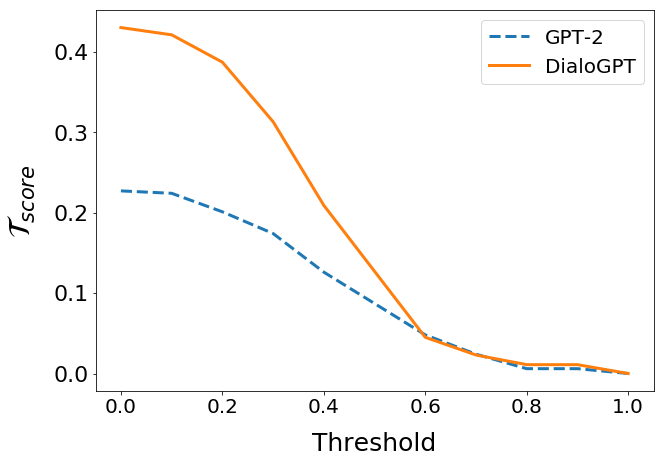

In [14]:
import glob, os
import matplotlib.pyplot as plt

csv_files = glob.glob(os.path.join('eval_results/temp1', "*.csv"))

model_evals = {
        'GPT-2':'dialog_ft_gpt2_devtest_eval_temp1_0604_v',
        'DialoGPT':'dialog_ft_dgpt_devtest_eval_temp1_0604_v'
    }

threshs = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]
path_to_output = './'

m_incorr = []
m_corr = []
# legend = ['DialoGPT FT', 'GPT FT']

# f, ax1 = plt.subplots(1, 2, figsize=(10,5))
plt.figure(figsize=(10, 7))

flag = 0
for i in model_evals:
    print('Model:', i)
    trust_corr = [0]*len(threshs)
    
    for j in range(3):

        temp_corr = []

        for thresh in threshs:
            scr = get_final_scores('eval_results/temp1/'+model_evals[i]+str(j)+'.csv', path_to_output, thresh).mean()['trust_score_corrdiag']
            temp_corr.append(scr)
        
        trust_corr = [v+temp_corr[k] for k,v in enumerate(trust_corr)]
        
    trust_corr = [round(k/3, 3) for k in trust_corr]
    print(trust_corr)
    if flag == 0:
        plt.plot(threshs, trust_corr, label = i, linewidth = 3, linestyle = 'dashed')
        flag = 1
    else:
        plt.plot(threshs, trust_corr, label = i, linewidth = 3)
        
    m_corr.append(trust_corr)

# plt.title('Threshold vs Trust')

plt.xlabel('Threshold', labelpad = 15, fontsize=25)
plt.ylabel('$\mathcal{T}_{score}$', labelpad = 15, fontsize=30)
plt.rc('font', size=12)
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('legend', fontsize=20)
plt.legend()

plt.savefig('lineplot_results.pdf', bbox_inches='tight')

In [18]:
# # import glob, os
# # import matplotlib.pyplot as plt

# # csv_files = glob.glob(os.path.join('eval_results/temp1', "*.csv"))

# # model_evals = {
# #         'MedDialog GPT2':'dialog_ft_gpt2_devtest_eval_temp1_0604_v',
# #         'MedDialog DialoGPT':'dialog_ft_dgpt_devtest_eval_temp1_0604_v'
# #     }

# # threshs = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]

# # m_incorr = []
# # m_corr = []
# # legend = ['DialoGPT FT', 'GPT FT', 'DialoGPT Vanilla', 'GPT Vanilla']

# # # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# # for i in model_evals:
# #     trust_corr = []
    
# #     for i in range(3):

# #         temp_corr = []

# #         for thresh in threshs:
# #             df = get_final_scores(i, thresh)
# #             trust_corr.append(df.mean()['trust_score_corrdiag'])
# #             trust_incorr.append(df.mean()['trust_score_incorr_diag'])

# #     ax1.plot(threshs, trust_corr)
# #     ax2.plot(threshs, trust_incorr)
# #     m_incorr.append(trust_incorr)
# #     m_corr.append(trust_corr)
# # sxs
# # ax1.set_title('Threshold vs Trust correct diagnosied')
# # ax1.set_xlabel('threshold')
# # ax1.set_ylabel('trust correct diagnosed')

# # # ax2.set_xlabel('threshold')
# # # ax2.set_ylabel('trust incorrect diagnosed')
# # # ax2.set_title('Threshold vs Trust incorrect diagnosed')

# # plt.legend(legend)

# # plt.show()


# import glob, os
# import matplotlib.pyplot as plt

# threshs = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

# trust_incorr = []
# trust_corr = []
# # legend = ['DialoGPT FT', 'GPT FT', 'DialoGPT Vanilla', 'GPT Vanilla']

# model_evals = {
# #         'Vanilla GPT2':'dialog_noft_gpt2_devtest_eval_temp2_0510_v',
#         'MedDialog GPT2':'dialog_ft_gpt2_devtest_eval_temp1_0604_v',
# #         'Vanilla DialoGPT':'dialog_noft_dgpt_devtest_eval_temp2_0510_v',
#         'MedDialog DialoGPT':'dialog_ft_dgpt_devtest_eval_temp1_0604_v'
#     }
    
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


# for thresh in threshs:
#     t, tinc = get_trust_means()
#     trust_corr.append()
#     trust_incorr.append(df.mean()['trust_score_incorr_diag'])

# ax1.plot(threshs, trust_corr)
# ax2.plot(threshs, trust_incorr)
# m_incorr.append(trust_incorr)
# m_corr.append(trust_corr)
    
# ax1.set_title('Threshold vs Trust correct diagnosied')
# ax1.set_xlabel('threshold')
# ax1.set_ylabel('trust correct diagnosed')

# ax2.set_xlabel('threshold')
# ax2.set_ylabel('trust incorrect diagnosed')
# ax2.set_title('Threshold vs Trust incorrect diagnosed')

# plt.legend(legend)

# plt.show()

In [46]:
sorted(df.sym_score.unique())

[0.0,
 0.1,
 0.14285714285714285,
 0.2,
 0.2222222222222222,
 0.25,
 0.2857142857142857,
 0.3,
 0.3333333333333333,
 0.375,
 0.4,
 0.42857142857142855,
 0.4444444444444444,
 0.5,
 0.5555555555555556,
 0.5714285714285714,
 0.6,
 0.625,
 0.6666666666666666,
 0.7,
 0.7142857142857143,
 0.75,
 0.8]

[0.42857143 0.4        0.25       0.5        0.2        0.44444444
 0.28571429 0.33333333 0.6        0.66666667 0.         0.55555556
 0.1        0.375      0.22222222 0.125      0.3        0.14285714
 0.16666667]


<AxesSubplot:>

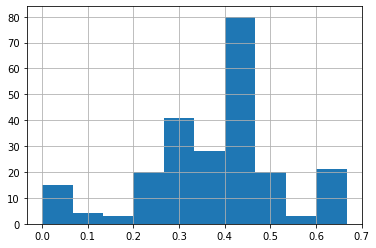

In [55]:
print((df['sym_score'].unique()))
df['sym_score'].hist()

## Incorrectly Diagnosed Disease Distribution

In [87]:
# Calculating final scores

def get_final_scores(path_to_results, thresh):
    res_df = pd.read_csv(path_to_results)
    res_df['avg_sen_score'] = res_df['dialog_id'].groupby(res_df['dialog_id']).transform('count')
    res_df = res_df.drop_duplicates(subset='dialog_id', keep='last')

    res_df['trust_score_corrdiag'] = res_df.apply(lambda x: get_trust(x, 1, thresh), axis=1)
    res_df['trust_score_incorr_diag'] = res_df.apply(lambda x: get_trust(x, 0, thresh), axis=1)
#     res_df['dialog_id'] = res_df['dialog_id'].apply(lambda x: int(x))
    res_df = res_df.merge(data_df[['remaining_sym', 'disease_tag', 'dialog_id']], on = 'dialog_id')

#     res_df = res_df[['dialog_id','avg_sen_score','sym_score','diag_score','trust_score_corrdiag','trust_score_incorr_diag']]
#     res_df.to_csv(path_to_output)
    return res_df

def get_trust(row, diag, thresh):
    if row['diag_score'] != diag:
        return 0
    if row['sym_score'] < thresh:
        return 0
    return 1



array(['Esophagitis', 'Enteritis', 'Asthma', 'Coronary heart disease',
       'Pneumonia', 'Rhinitis', 'Thyroiditis', 'Traumatic brain injury',
       'Dermatitis', 'External otitis', 'Conjunctivitis', 'Mastitis'],
      dtype=object)

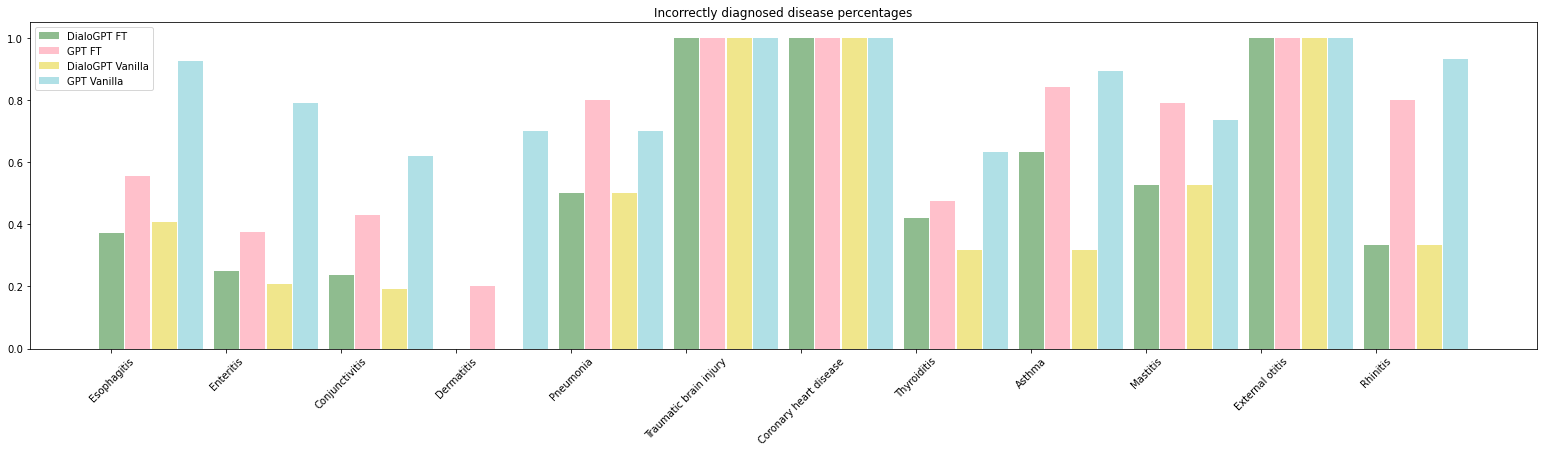

In [152]:
import numpy as np
fig, ax = plt.subplots(figsize=(27,6))
total_dis_dict = dict(data_df.disease_tag.value_counts())
labels = total_dis_dict.keys()
x = np.arange(len(labels))
w = 0
legend = ['DialoGPT FT', 'GPT FT', 'DialoGPT Vanilla', 'GPT Vanilla']
clr = ['darkseagreen','pink','khaki','powderblue']

for k,j in enumerate(csv_files):
    df = get_final_scores(j, 0.2)
    dis_incorr_dict = dict(df[df['diag_score']==0].disease_tag.value_counts())
    dis_incorr_dict_pct = {}
    for i in labels:
        if i in dis_incorr_dict.keys():
            dis_incorr_dict_pct[i] = dis_incorr_dict[i]/total_dis_dict[i]
        else:
            dis_incorr_dict_pct[i] = 0

    ax.bar(x+w, dis_incorr_dict_pct.values(), width = 0.22, label=legend[k], color=clr[k])
    w += 0.23

plt.title('Incorrectly diagnosed disease percentages')
plt.xticks(x, labels, rotation=45)
plt.legend(legend)
plt.show()

In [83]:
df

,input,sys_out,score,diag_score,dialog_id,sym_score,avg_sen_score,trust_score_corrdiag,trust_score_incorr_diag
6,"Patient: Thank you Doctor, Doctor:?",I believe you are having from Esopharynx dis...,0,1,1.0,0.428571,7,1,0
16,"Patient: Thank you Doctor, Doctor:?",. and shortestion? and mucous membranes?,0,0,2.0,0.400000,10,0,1
20,"Patient: Thank you Doctor, Doctor:?",,0,0,3.0,0.250000,4,0,1
30,"Patient: Thank you Doctor, Doctor:?",i believe you have,0,0,4.0,0.500000,10,0,1
40,"Patient: No, I don't have that, Doctor: ?",�,0,0,5.0,0.200000,10,0,1
...,...,...,...,...,...,...,...,...,...
1675,"Patient: Thank you Doctor, Doctor:?",i believe you are having from Enteritis.,0,0,231.0,0.500000,8,0,1
1677,"Patient: Thank you Doctor, Doctor:?",,0,1,232.0,0.000000,2,0,0
1682,"Patient: Thank you Doctor, Doctor:?",,0,0,233.0,0.400000,5,0,1
1690,"Patient: Thank you Doctor, Doctor:?",�,0,1,234.0,0.375000,8,1,0


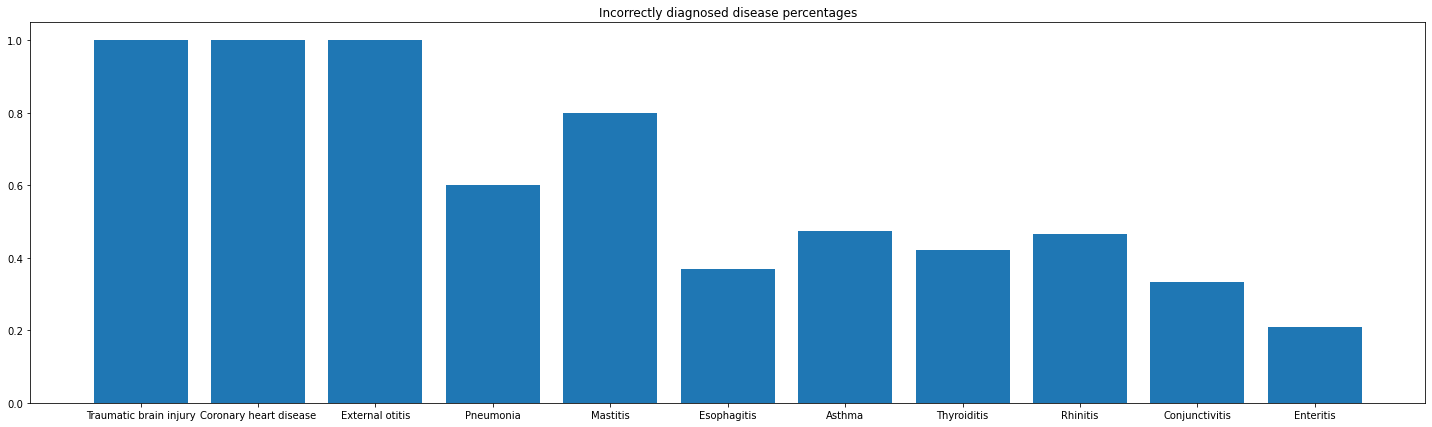

In [60]:
total_dis_dict = dict(df.disease_tag.value_counts())
dis_incorr_dict = dict(df[df['diag_score']==0].disease_tag.value_counts())
dis_incorr_dict_pct = {}
for i in dis_incorr_dict:
    dis_incorr_dict_pct[i] = dis_incorr_dict[i]/total_dis_dict[i]

plt.figure(figsize=(25,7))    
plt.bar(dis_incorr_dict_pct.keys(), dis_incorr_dict_pct.values())
plt.title('Incorrectly diagnosed disease percentages')
plt.show()

## Train Data Disease Distribution

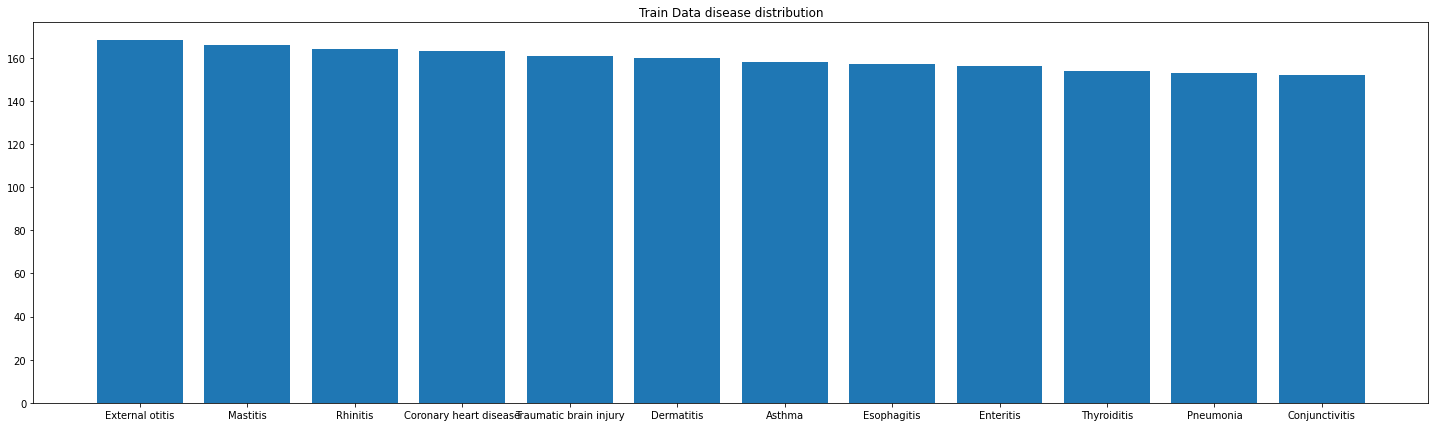

In [66]:
train_df = pd.read_pickle('MDD_dataset/train.pk')
train_df = pd.DataFrame(train_df)
dis_count = dict(train_df.disease_tag.value_counts())

plt.figure(figsize=(25,7))    
plt.bar(dis_count.keys(), dis_count.values())
plt.title('Train Data disease distribution')
plt.show()

In [25]:
# Calculating num sentences wise final scores

def get_final_scores(path_to_results, num_sentences):
    res_df = pd.read_csv(path_to_results)
    res_df = res_df.merge(data_df[['remaining_sym', 'disease_tag', 'dialog_id']], on = 'dialog_id')
    
    res_df['sentence_score'] = res_df['dialog_id'].groupby(res_df['dialog_id']).transform('count')
    
#     res_df = get_num_sen(num_sentences, res_df)
    
    res_df['avg_diag_sym_score'] = res_df.groupby(res_df['dialog_id'])['dialog_sym_score'].transform('sum')
    res_df['avg_diag_sym_score'] = res_df.apply(lambda x: x['avg_diag_sym_score']/len(x['remaining_sym']), axis=1)
    
    res_df['sym_score'] = res_df['score'].groupby(res_df['dialog_id']).transform('sum')
    res_df['sym_score'] = res_df.apply(lambda x: x['sym_score']/num_sentences-1 if num_sentences!=10 else x['sym_score']/9, axis=1)
    res_df['weighted_sym_score'] = res_df['sym_score'].apply(lambda x: x*min(num_sentences-1, )/max(num_sentences-1, )) 
    res_df = res_df.drop_duplicates(subset='dialog_id', keep='last')
    res_df['trust_score_corrdiag'] = res_df.apply(lambda x: get_trust(x, 1), axis=1)
    res_df['trust_score_incorr_diag'] = res_df.apply(lambda x: get_trust(x, 0), axis=1)
    res_df = res_df[['dialog_id','sentence_score','sym_score','diag_score','avg_diag_sym_score','trust_score_corrdiag','trust_score_incorr_diag']]
    return res_df

def get_trust(row, diag):
    if row['diag_score'] != diag:
        return 0
    if row['sym_score'] < 0.4:
        return 0
    return 1

def get_num_sen(num_sentences, df):
    ls = []
    for i in df.dialog_id.unique():
        if len(df[df['dialog_id'] == i])-1 < num_sentences:
            pass
        else:
            ls.append(df[df['dialog_id'] == i][:num_sentences])
    return pd.concat(ls, ignore_index=True)

In [27]:
path_to_results = 'eval_results/dialog_noft_dgpt_devtest_eval_temp2_0510_v0.csv'
vanilla_dgpt = []
for i in range(1,10):
    df = get_final_scores(path_to_results, i)
    print('Symptom score for', i, 'dialog sentences:', df.mean()['sym_score'])
    vanilla_dgpt.append(df.mean()['sym_score'])

Symptom score for 1 dialog sentences: 0.7021276595744681
Symptom score for 2 dialog sentences: 0.35319148936170214
Symptom score for 3 dialog sentences: 0.2617702448210927
Symptom score for 4 dialog sentences: 0.23076923076923078
Symptom score for 5 dialog sentences: 0.17435897435897443
Symptom score for 6 dialog sentences: 0.14583333333333334
Symptom score for 7 dialog sentences: 0.1275510204081632
Symptom score for 8 dialog sentences: 0.11
Symptom score for 9 dialog sentences: 0.09090909090909093


In [28]:
path_to_results = 'eval_results/dialog_noft_gpt2_devtest_eval_temp2_0510_v0.csv'
vanilla_gpt2 = []
for i in range(1,10):
    df = get_final_scores(path_to_results, i)
    print('Symptom score for', i, 'dialog sentences:', df.mean()['sym_score'])
    vanilla_gpt2.append(df.mean()['sym_score'])

Symptom score for 1 dialog sentences: 0.6467889908256881
Symptom score for 2 dialog sentences: 0.7382075471698113
Symptom score for 3 dialog sentences: 0.5970149253731346
Symptom score for 4 dialog sentences: 0.6067708333333334
Symptom score for 5 dialog sentences: 0.5565217391304346
Symptom score for 6 dialog sentences: 0.5129107981220656
Symptom score for 7 dialog sentences: 0.47163865546218475
Symptom score for 8 dialog sentences: 0.41875
Symptom score for 9 dialog sentences: 0.3751375137513748


In [29]:
path_to_results = 'eval_results/dialog_ft_dgpt_devtest_eval_temp2_0510_v0.csv'
meddialog_dgpt = []
for i in range(1,10):
    df = get_final_scores(path_to_results, i)
    print('Symptom score for', i, 'dialog sentences:', df.mean()['sym_score'])
    meddialog_dgpt.append(df.mean()['sym_score'])

Symptom score for 1 dialog sentences: 0.641860465116279
Symptom score for 2 dialog sentences: 0.46634615384615385
Symptom score for 3 dialog sentences: 0.5129533678756479
Symptom score for 4 dialog sentences: 0.42473118279569894
Symptom score for 5 dialog sentences: 0.415748031496063
Symptom score for 6 dialog sentences: 0.39138576779026196
Symptom score for 7 dialog sentences: 0.34161490683229784
Symptom score for 8 dialog sentences: 0.31862745098039214
Symptom score for 9 dialog sentences: 0.28042328042328046


In [31]:
path_to_results = 'eval_results/dialog_ft_gpt2_devtest_eval_temp2_0510_v0.csv'
meddialog_gpt2 = []
for i in range(1,10):
    df = get_final_scores(path_to_results, i)
    print('Symptom score for', i, 'dialog sentences:', df.mean()['sym_score'])
    meddialog_gpt2.append(df.mean()['sym_score'])

Symptom score for 1 dialog sentences: 0.6018518518518519
Symptom score for 2 dialog sentences: 0.44607843137254904
Symptom score for 3 dialog sentences: 0.5617977528089891
Symptom score for 4 dialog sentences: 0.5633116883116883
Symptom score for 5 dialog sentences: 0.5235294117647061
Symptom score for 6 dialog sentences: 0.48205128205128217
Symptom score for 7 dialog sentences: 0.44642857142857123
Symptom score for 8 dialog sentences: 0.43487394957983194
Symptom score for 9 dialog sentences: 0.4166666666666663


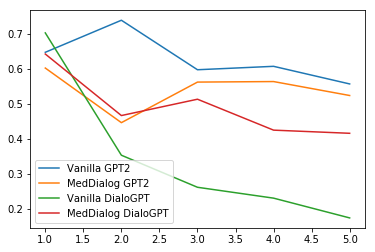

In [34]:
import matplotlib.pyplot as plt
models = {
    'Vanilla GPT2':vanilla_gpt2,
    'MedDialog GPT2':meddialog_gpt2,
    'Vanilla DialoGPT':vanilla_dgpt,
    'MedDialog DialoGPT':meddialog_dgpt
}
for i in models:
    plt.plot(range(1,6), models[i][:5])
    plt.legend(models.keys())
plt.show()